# SWaT 오픈 데이터셋을 이용한 LSTM 학습
- 미니콘다 가상환경명: bizpy3.9 (numpy ver < 2 에서만 동작 가능)

In [1]:
# 프로젝트 root(sys.path) 설정파일 호출 (없으면 루트를 현재 파일이 있는 폴더로 인식함)
%run _setup.py

# __init__.py “이 폴더는 파이썬 패키지” 의미

## 라이브러리 import + 설정

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 재현성

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 파일 경로 지정

In [3]:
NORMAL_CSV = r"C:\ai_dev\jupyter\test\ts_swat_lstm\data\raw\normal.csv"
ATTACK_CSV = r"C:\ai_dev\jupyter\test\ts_swat_lstm\data\raw\attack.csv"

assert os.path.exists(NORMAL_CSV), "NORMAL_CSV 경로 틀림"
assert os.path.exists(ATTACK_CSV), "ATTACK_CSV 경로 틀림"
print("OK")

OK


## CSV 로드 + Timestamp 파싱 + 라벨컬럼 

In [4]:
def load_swat_csv(path: str):
    df = pd.read_csv(path)

    # Timestamp 컬럼명 정리 (공백/대소문자 대비)
    # 보통 'Timestamp' 그대로인데 혹시 몰라서 방어
    ts_candidates = [c for c in df.columns if c.strip().lower() == "timestamp"]
    assert len(ts_candidates) == 1, f"Timestamp 컬럼을 못 찾음: {ts_candidates}"
    ts_col = ts_candidates[0]

    # 날짜 포맷: 28/12/2015 10:29:14 AM (일/월/년)
    df[ts_col] = pd.to_datetime(df[ts_col], dayfirst=True, errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)

    # 라벨 컬럼: 보통 마지막에 'Normal/Attack'
    label_candidates = [c for c in df.columns if "normal" in c.lower() and "attack" in c.lower()]
    if len(label_candidates) == 0:
        # 못 찾으면 마지막 컬럼을 라벨로 가정 (데이터셋 구조상 마지막 컬럼이 normal/attack 이어서)
        label_col = df.columns[-1]
    else:
        label_col = label_candidates[0]

    return df, ts_col, label_col

df_normal, ts_col, label_col = load_swat_csv(NORMAL_CSV)
df_attack, ts_col2, label_col2 = load_swat_csv(ATTACK_CSV)

assert ts_col == ts_col2
assert label_col == label_col2
print("Timestamp:", ts_col)
print("Label:", label_col)
print(df_normal.shape, df_attack.shape)
df_normal.head(2)


Timestamp:  Timestamp
Label: Normal/Attack
(1387093, 53) (54621, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2015-12-22 16:00:00,2.470294,261.5804,NaN,2,1,NaN,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,2015-12-22 16:00:01,2.457163,261.1879,NaN,2,1,NaN,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


## Feature 컬럼 선택 + 라벨 정리

In [5]:
# feature = Timestamp, 라벨 제외한 나머지 전부
feature_cols = [c for c in df_normal.columns if c not in [ts_col, label_col]]

# 혹시 숫자 아닌 컬럼이 섞여 있으면 제거
numeric_feature_cols = []
for c in feature_cols:
    if pd.api.types.is_numeric_dtype(df_normal[c]):
        numeric_feature_cols.append(c)

feature_cols = numeric_feature_cols
print("num_features:", len(feature_cols))

# 라벨을 0/1로
def label_to_binary(s):
    # "Normal" -> 0, "Attack" -> 1
    s = str(s).strip().lower()
    return 1 if "attack" in s else 0

df_normal["y"] = df_normal[label_col].apply(label_to_binary)
df_attack["y"] = df_attack[label_col].apply(label_to_binary)

# Normal 파일은 보통 다 0이어야 정상
print("normal y counts:", df_normal["y"].value_counts().to_dict())
print("attack y counts:", df_attack["y"].value_counts().to_dict())


num_features: 51
normal y counts: {0: 1387093}
attack y counts: {1: 54621}


## 결측 처리 + 스케일링 (train=normal 기준으로 fit)

In [11]:
# 결측 보간(센서 결측 대응): 앞/뒤로 채우고 남은 건 0
def clean_features(df):
    x = df[feature_cols].copy()
    x = x.replace([np.inf, -np.inf], np.nan)
    x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
    return x

X_train_raw = clean_features(df_normal)
X_test_raw  = clean_features(df_attack)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw.values)
X_test  = scaler.transform(X_test_raw.values)

y_test = df_attack["y"].values
y_train = df_normal["y"].values

print(X_train.shape, X_test.shape)

C:\Users\bizforce\AppData\Local\Temp\ipykernel_11468\1414439965.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\bizforce\AppData\Local\Temp\ipykernel_11468\1414439965.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)


(1387093, 51) (54621, 51)


## Cell 5) 슬라이딩 윈도우 Dataset (10초 샘플 기준 윈도우 추천 포함)
### 10초마다 1개니까
- 10분 = 60포인트
- 30분 = 180포인트
- 1시간 = 360포인트
### 일단 30분(180)으로 시작

In [13]:
from src.data.dataset import SlidingWindowDataset

window_size = 180
stride = 1

train_ds = SlidingWindowDataset(X_train, y=None, window_size=window_size, stride=stride)
test_ds  = SlidingWindowDataset(X_test,  y_test, window_size=window_size, stride=stride)  # (x, y_win)

## DataLoader

In [14]:
BATCH_SIZE = 64  # 4070 8GB면 보통 이 정도는 안정권
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [18]:
# DataLoader로 꺼냈을 때 shape

dl = DataLoader(train_ds, batch_size=8, shuffle=True)
x = next(iter(dl))
print(x.shape)  # (B, T, F) 여야 함

dl_t = DataLoader(test_ds, batch_size=8, shuffle=False)
x, y = next(iter(dl_t))
print(x.shape, y.shape)  # (B, T, F), (B,)

torch.Size([8, 180, 51])
torch.Size([8, 180, 51]) torch.Size([8])


## 학습 루프 (AMP 옵션 포함)

In [19]:
from omegaconf import OmegaConf
from src.train import train_from_loaders

# config 로드 (notebooks 기준 경로)
cfg = OmegaConf.load("../configs/exp_lstm_ae.yaml")

# train.py 호출
result = train_from_loaders(
    cfg,
    train_loader=train_loader,
    val_loader=None,        # 지금은 validation 없으니까
)

result

Epoch 001 | train=0.094240
Epoch 002 | train=0.061482
Epoch 003 | train=0.056274
Epoch 004 | train=0.053744
Epoch 005 | train=0.053055
Epoch 006 | train=0.051031
Epoch 007 | train=0.049853
Epoch 008 | train=0.048206
Epoch 009 | train=0.049609
Epoch 010 | train=0.048473
Epoch 011 | train=0.047221
Epoch 012 | train=0.120526
Epoch 013 | train=0.595771
Epoch 014 | train=0.497532
Epoch 015 | train=0.256684
Epoch 016 | train=0.572386
Epoch 017 | train=0.215006
Epoch 018 | train=0.473773
Epoch 019 | train=0.110243
Epoch 020 | train=0.086086
Epoch 021 | train=0.721074
Epoch 022 | train=0.093336
Epoch 023 | train=0.080544
Epoch 024 | train=0.073249
Epoch 025 | train=0.066570
Epoch 026 | train=0.061129
Epoch 027 | train=0.057542
Epoch 028 | train=0.053161
Epoch 029 | train=0.050958
Epoch 030 | train=0.048330


{'run_dir': 'runs\\2026-01-12_16-43-05_lstm_ae_swat',
 'history': {'train_loss': [0.09424015888614416,
   0.06148240887258034,
   0.056273978907012405,
   0.05374386621208068,
   0.05305517770359219,
   0.05103072173672977,
   0.049853119873042064,
   0.04820558134682157,
   0.04960895613198829,
   0.04847322942668217,
   0.04722054415628706,
   0.1205257078541815,
   0.5957712868126268,
   0.497532396727548,
   0.2566838267073207,
   0.5723863761793834,
   0.215005790106574,
   0.47377312272360755,
   0.1102427119552491,
   0.08608593546304497,
   0.7210736527057802,
   0.09333578223593784,
   0.08054434663513405,
   0.07324850244166516,
   0.06657009014748484,
   0.06112915582051926,
   0.05754184584921105,
   0.05316139530789332,
   0.05095771798690163,
   0.04833047698769997],
  'val_loss': [None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None

## 평가 셀 1: 모델 로드 + device 준비

In [20]:
import torch
import numpy as np
from omegaconf import OmegaConf
from src.models.lstm import LSTMAutoEncoder

# train.py 실행 결과(result)에서 last ckpt 경로 사용
ckpt_path = result["last_model_path"]
ckpt = torch.load(ckpt_path, map_location="cpu")

cfg_ckpt = OmegaConf.create(ckpt["cfg"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAutoEncoder(
    n_features=int(cfg_ckpt.model.n_features),
    hidden_size=int(cfg_ckpt.model.hidden_size),
    num_layers=int(cfg_ckpt.model.num_layers),
    dropout=float(cfg_ckpt.model.dropout),
).to(device)

model.load_state_dict(ckpt["model"])
model.eval()

print("loaded:", ckpt_path)
print("device:", device)


loaded: runs\2026-01-12_16-43-05_lstm_ae_swat\model_last.pt
device: cuda


## 평가 셀 2: recon error(윈도우 점수) 계산 함수

In [21]:
import torch

@torch.no_grad()
def compute_window_scores(model, loader, device):
    model.eval()
    scores = []
    labels = []

    for batch in loader:
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y_win = batch
            labels.extend(y_win.numpy().tolist())
        else:
            x = batch

        x = x.to(device)
        x_hat = model(x)

        mse = ((x_hat - x) ** 2).mean(dim=(1,2)).detach().cpu().numpy()
        scores.extend(mse.tolist())

    scores = np.array(scores, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64) if len(labels) > 0 else None
    return scores, labels


## 셀 3: train/test 점수 + threshold + F1

In [22]:
from torch.utils.data import DataLoader

BATCH_SIZE = int(cfg_ckpt.train.batch_size)

train_loader_eval = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
# test_loader는 이미 만들었으면 그거 그대로 써도 됨 (shuffle=False 권장)

train_scores, _ = compute_window_scores(model, train_loader_eval, device)
test_scores, test_labels = compute_window_scores(model, test_loader, device)

PCTL = 99.5
threshold = np.percentile(train_scores, PCTL)
pred = (test_scores > threshold).astype(int)

tp = int(((pred == 1) & (test_labels == 1)).sum())
tn = int(((pred == 0) & (test_labels == 0)).sum())
fp = int(((pred == 1) & (test_labels == 0)).sum())
fn = int(((pred == 0) & (test_labels == 1)).sum())

precision = tp / (tp + fp + 1e-9)
recall    = tp / (tp + fn + 1e-9)
f1        = 2 * precision * recall / (precision + recall + 1e-9)

print(f"threshold(p{PCTL}) = {threshold:.6f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


threshold(p99.5) = 0.374955
TP=44880, FP=0, TN=0, FN=9562
Precision=1.0000, Recall=0.8244, F1=0.9037


## 평가 셀 4: 그래프

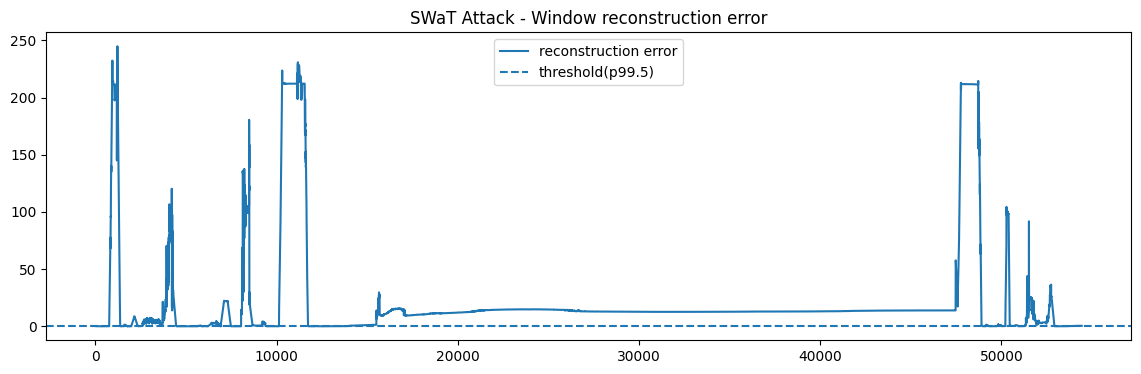

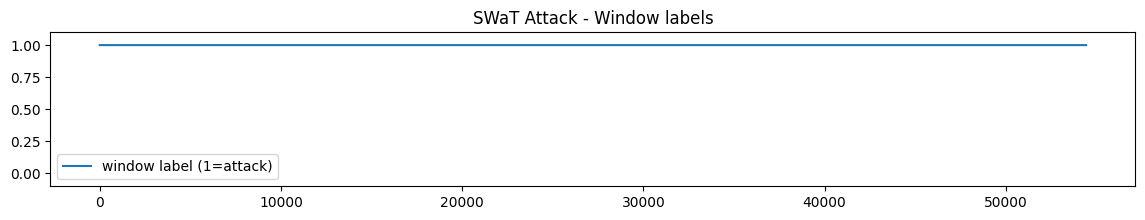

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(test_scores, label="reconstruction error")
plt.axhline(threshold, linestyle="--", label=f"threshold(p{PCTL})")
plt.title("SWaT Attack - Window reconstruction error")
plt.legend()
plt.show()

plt.figure(figsize=(14,2))
plt.plot(test_labels, label="window label (1=attack)")
plt.title("SWaT Attack - Window labels")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()


## 평가셀 5: ROC / PR-AUC

ROC-AUC = nan
PR-AUC  = 1.0000


C:\Users\bizforce\miniconda3\envs\bizpy3.9\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\bizforce\miniconda3\envs\bizpy3.9\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


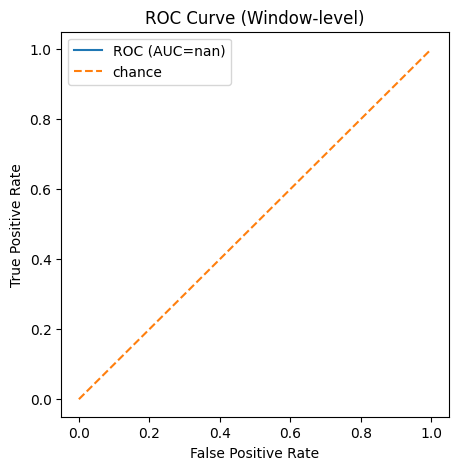

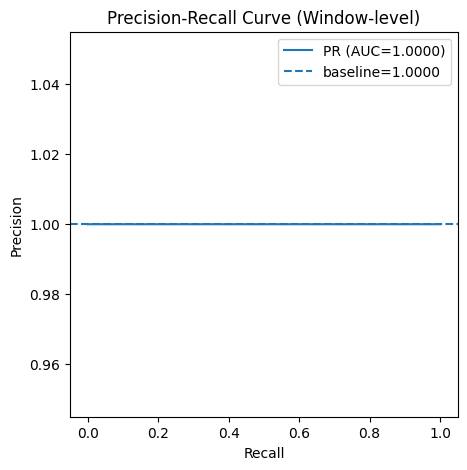

In [24]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

# test_labels가 None이면 PR/ROC 계산 못 함
if test_labels is None:
    print("test_labels가 없어서 ROC/PR-AUC 계산을 스킵")
else:
    # AUC 계산 (threshold 없이 '점수' 자체로 평가)
    roc_auc = roc_auc_score(test_labels, test_scores)
    pr_auc  = average_precision_score(test_labels, test_scores)

    print(f"ROC-AUC = {roc_auc:.4f}")
    print(f"PR-AUC  = {pr_auc:.4f}")

    # 곡선 좌표
    fpr, tpr, _ = roc_curve(test_labels, test_scores)
    prec, rec, _ = precision_recall_curve(test_labels, test_scores)

    # ROC curve
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
    plt.plot([0,1], [0,1], linestyle="--", label="chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Window-level)")
    plt.legend()
    plt.show()

    # PR curve
    plt.figure(figsize=(5,5))
    plt.plot(rec, prec, label=f"PR (AUC={pr_auc:.4f})")
    # 참고: baseline(양성 비율)
    pos_rate = float(np.mean(test_labels))
    plt.axhline(pos_rate, linestyle="--", label=f"baseline={pos_rate:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Window-level)")
    plt.legend()
    plt.show()
